# Using word2vec + fully connected neural networks to finish “⾖豆瓣评论” classification

## 1. 加载数据

In [1]:
import pandas as pd
fname = 'movie_comments.csv'
df = pd.read_csv(fname, encoding='utf8')

df.head(10)

D:\Program\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1
5,6,https://movie.douban.com/subject/26363254/,战狼2,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,7,https://movie.douban.com/subject/26363254/,战狼2,脑子是个好东西，希望编剧们都能有。,2
7,8,https://movie.douban.com/subject/26363254/,战狼2,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,9,https://movie.douban.com/subject/26363254/,战狼2,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,10,https://movie.douban.com/subject/26363254/,战狼2,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


In [2]:
df.shape

(261497, 5)

## 2. 预处理数据

In [3]:
# 只使用comment和star两列
df = df[['comment', 'star']]
# 删除comment为空的数据
df = df[pd.notnull(df['comment'])]
df.head(10)

,comment,star
0,吴京意淫到了脑残的地步，看了恶心想吐,1
1,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,中二得很,1
5,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,脑子是个好东西，希望编剧们都能有。,2
7,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


In [4]:
df.shape

(261495, 2)

In [5]:
# 重新索引数据
df.index = range(261495)

In [3]:
import re
import jieba

def preprocess(comments):
    pattern = re.compile('[\u4E00-\u9FA5]')
    new_comments = []
    for comment in comments:
        only_chinese = pattern.findall(comment)
        chinese_comment = ''.join(only_chinese)
        chinese_tokens = jieba.cut(chinese_comment)
        new_comments.append(' '.join(chinese_tokens))
    return new_comments

In [4]:
comments = preprocess(df['comment'].tolist())

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DINGLI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.198 seconds.
Prefix dict has been built succesfully.


In [5]:
comments[0]

'吴京 意淫 到 了 脑残 的 地步 看 了 恶心 想 吐'

## 3.查看数据

In [7]:
count_star = df['star'].value_counts()

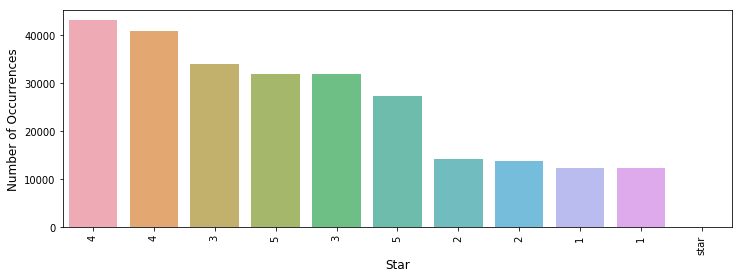

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,4))
sns.barplot(count_star.index, count_star.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Star', fontsize=12)
plt.xticks(rotation=90)
plt.show()

 ## get sentence vector from word2vec

In [ ]:
# -*- coding:utf8 -*-
from gensim.models import KeyedVectors
import pickle as pkl
import numpy as np
from typing import List
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import os
import PSLvec as psl
from nltk.tokenize import StanfordTokenizer

word2vec_path = './GoogleNews-vectors-negative300.bin.gz'
glove_path = './glove_model.txt'
psl_path = './PSL_model.txt'
# traindata = './datasets/sts2013.OnWN.pkl'
freq_table = './mydictionary'
embedding_size = 300

pslemb = psl.PSL()

# 载入word2vec模型
# model = KeyedVectors.load_word2vec_format(word2vec_path,binary=True)
# model = KeyedVectors.load_word2vec_format(glove_path,binary=False)
# model = KeyedVectors.load_word2vec_format(psl_path,binary=False)
model = pslemb.w
print('完成模型载入')

tokenizer = StanfordTokenizer(path_to_jar=r"D:\stanford-parser-full-2016-10-31\stanford-parser.jar")


# print(type(model))
# print(model['sdfsfsdfsadfs'])

class Word:
    def __init__(self, text, vector):
        self.text = text
        self.vector = vector


class Sentence:
    def __init__(self, word_list):
        self.word_list = word_list

    def len(self) -> int:
        return len(self.word_list)


def get_word_frequency(word_text, looktable):
    if word_text in looktable:
        return looktable[word_text]
    else:
        return 1.0


def sentence_to_vec(sentence_list: List[Sentence], embedding_size, looktable, a=1e-3):
    sentence_set = []
    for sentence in sentence_list:
        vs = np.zeros(embedding_size)  # add all word2vec values into one vector for the sentence
        sentence_length = sentence.len()
        for word in sentence.word_list:
            a_value = a / (a + get_word_frequency(word.text, looktable))  # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word.vector))  # vs += sif * word_vector

        vs = np.divide(vs, sentence_length)  # weighted average
        sentence_set.append(vs)  # add to our existing re-calculated set of sentences

    # calculate PCA of this sentence set
    pca = PCA(n_components=embedding_size)
    pca.fit(np.array(sentence_set))
    u = pca.components_[0]  # the PCA vector
    u = np.multiply(u, np.transpose(u))  # u x uT

    # pad the vector?  (occurs if we have less sentences than embeddings_size)
    if len(u) < embedding_size:
        for i in range(embedding_size - len(u)):
            u = np.append(u, 0)  # add needed extension for multiplication below

    # resulting sentence vectors, vs = vs -u x uT x vs
    sentence_vecs = []
    for vs in sentence_set:
        sub = np.multiply(u, vs)
        sentence_vecs.append(np.subtract(vs, sub))

    return sentence_vecs


with open(freq_table, 'rb') as f:
    mydict = pkl.load(f)
print('完成词频字典载入')

paths = ['./datasets/data']
for path in paths:
    files = []
    for file in os.listdir(path=path):
        if os.path.isfile(path + '/' + file):
            files.append(path + '/' + file)

    for traindata in files:
        with open(traindata, 'rb') as f:
            train = pkl.load(f)

        print('读取' + traindata + '数据完成')

        gs = []
        pred = []
        allsent = []
        for each in train:
            # sent1, sent2, label = each.split('\t')
            if len(train[0]) == 3:
                sent1, sent2, label = each
            else:
                sent1, sent2, label, _ = each
            gs.append(float(label))
            s1 = []
            s2 = []
            # sw1 = sent1.split()
            # sw2 = sent2.split()
            for word in sent1:
                try:
                    vec = model[word]
                except KeyError:
                    vec = np.zeros(embedding_size)
                s1.append(Word(word, vec))
            for word in sent2:
                try:
                    vec = model[word]
                except KeyError:
                    vec = np.zeros(embedding_size)
                s2.append(Word(word, vec))

            ss1 = Sentence(s1)
            ss2 = Sentence(s2)
            allsent.append(ss1)
            allsent.append(ss2)

        sentence_vectors = sentence_to_vec(allsent, embedding_size, looktable=mydict)
        len_sentences = len(sentence_vectors)
        for i in range(len_sentences):
            if i % 2 == 0:
                sim = cosine_similarity([sentence_vectors[i]], [sentence_vectors[i + 1]])
                pred.append(sim[0][0])

        print('len of pred: ', len(pred))
        print('len of gs: ', len(gs))

        r, p = pearsonr(pred, gs)
        print(traindata + '皮尔逊相关系数:', r)


        # sentence_vectors = sentence_to_vec([ss1, ss2], embedding_size, looktable=mydict)
        # sim = cosine_similarity([sentence_vectors[0]], [sentence_vectors[1]])
        # pred.append(sim[0][0])

        # r, p = pearsonr(pred, gs)
        # print(traindata + '皮尔逊相关系数:', r)  # print(sentence_vectors[0])
# print(sentence_vectors[1])

. train neaual network model

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
num_nodes= 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation 
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    test_prediction =  tf.nn.softmax(logits_2)

In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))